In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob

In [2]:
results_path = '../Metrics/Results/'

In [3]:
csv_paths = sorted(glob(results_path + '*'))
csv_paths

['../Metrics/Results/cartolastd.csv',
 '../Metrics/Results/cifar10cnn.csv',
 '../Metrics/Results/esc50.csv',
 '../Metrics/Results/fashion.csv',
 '../Metrics/Results/gaussians.csv',
 '../Metrics/Results/nnset.csv',
 '../Metrics/Results/qtables.csv',
 '../Metrics/Results/quickdraw.csv',
 '../Metrics/Results/sorts.csv',
 '../Metrics/Results/walk.csv']

In [4]:
def get_method(name):
    s = name
    s = s.split('/')[1]
    s = s.split('-', 1)[1]

    if s.startswith('tsne'):
        return s[:7]
    elif s.startswith('dtsne'):
        return 'dtsne'
    elif s.startswith('pca'):
        return s[:6]
    else:
        return s.split('_')[0]


In [5]:
df_metrics = pd.DataFrame()
for p in csv_paths:
    df = pd.read_csv(p)
    df = df.drop(['spat_kl', 'stab_kl'], axis=1)  # Bad metric
    # Extract dataset and method into own column
    df.columns = np.concatenate([['name'], df.columns.values[1:]])
    df['dataset'] = df['name'].str.split('_', 1).str[0].str.extract(r'.*/(.*)-.*')
    df['method'] = df['name'].apply(get_method)
    df = df.set_index('name')
    
    # Average nh and np metrics 
    nh_cols = [c for c in df.columns if 'spat_nh_' in c]
    df['spat_nh_mean'] = np.mean(df[nh_cols], axis=1)
#     df = df.drop(nh_cols, axis=1)
    np_cols = [c for c in df.columns if 'spat_np_' in c]
    df['spat_np_mean'] = np.mean(df[np_cols], axis=1)
#     df = df.drop(np_cols, axis=1)
    df_metrics = pd.concat([df_metrics, df])

In [6]:
np_cols = [c for c in df.columns if 'spat_np_' in c]
np.mean(df[np_cols], axis=1)

name
Output/walk-AE_10f_10f_2f_20ep.csv      0.481985
Output/walk-VAE_100f_10f_2f_20ep.csv    0.481074
Output/walk-tsne_s1_30p.csv             0.476209
Output/walk-tsne_s4_30p.csv             0.462251
Output/walk-dtsne_100p_0-01l.csv        0.471319
Output/walk-pca_s1.csv                  0.483420
Output/walk-pca_s4.csv                  0.483167
dtype: float64

In [7]:
vs = []
indexes = []
for i, df in df_metrics.groupby('method'):
#     print(i), display(df)
    indexes.append(i)
    vs.append(np.mean(df, axis=0))

df_per_method = pd.DataFrame(vs, indexes)
df_per_method = df_per_method
# df_per_method.index = indexes
df_per_method = df_per_method.reindex(['AE', 'C2AE', 'VAE', 'C2VAE', 'tsne_s1', 'tsne_s4', 'dtsne', 'pca_s1', 'pca_s4'])

In [8]:
# Organize order before generating matrix
cols = ['stab_pearson', 'stab_spearman' , 'stab_kendall', 'stab_stress_n', 'stab_stress_s']
df_stab = df_per_method[cols]

cols = ['spat_pearson', 'spat_spearman' , 'spat_kendall', 'spat_stress_n', 'spat_stress_s']
df_spat_dists = df_per_method[cols]

cols = ['spat_nh_mean', 'spat_np_mean']
df_spat_neigh = df_per_method[cols]

blank = pd.DataFrame(np.zeros((len(df_stab), 1)), index=df_stab.index, columns=[' '])

df = pd.concat([df_stab, blank, df_spat_dists, blank, df_spat_neigh], axis=1)
df = df.drop(['C2AE', 'C2VAE'])

df

,stab_pearson,stab_spearman,stab_kendall,stab_stress_n,stab_stress_s,,spat_pearson,spat_spearman,spat_kendall,spat_stress_n,spat_stress_s,,spat_nh_mean,spat_np_mean
AE,0.486771,0.672234,0.564096,0.511469,1.026457,0.0,0.740004,0.804774,0.659133,0.231429,0.519991,0.0,0.050291,0.471675
VAE,0.549811,0.685276,0.581146,0.458045,0.900377,0.0,0.760023,0.803864,0.659512,0.225638,0.479954,0.0,0.050798,0.470478
tsne_s1,0.020008,0.002021,0.002212,17.835451,1.959983,0.0,0.477081,0.577056,0.442850,0.621005,1.045838,0.0,0.050301,0.471732
tsne_s4,0.329527,0.487952,0.386461,0.928513,1.340946,0.0,0.660217,0.704072,0.531389,0.609990,0.679565,0.0,0.044171,0.454743
dtsne,0.184220,0.192488,0.147888,3.320041,1.631561,0.0,0.609111,0.675699,0.514559,0.514577,0.781778,0.0,0.041477,0.457806
pca_s1,0.312698,0.453133,0.354881,0.926273,1.374603,0.0,0.784056,0.810542,0.669136,0.185815,0.431887,0.0,0.048245,0.476409
pca_s4,0.586277,0.673701,0.580383,0.389519,0.827446,0.0,0.778645,0.805928,0.665666,0.192350,0.442709,0.0,0.048357,0.475133


In [50]:
df_metrics.shape

(74, 114)

In [71]:
nh_np_cols = [c for c in df_metrics.columns if 'spat_nh_' in c or 'spat_np_' in c]
df_metrics_filtered = df_metrics.drop(columns=nh_np_cols)
df_metrics_filtered = df_metrics_filtered[df_metrics_filtered.method != 'C2AE']
df_metrics_filtered = df_metrics_filtered[df_metrics_filtered.method != 'C2VAE']
df_metrics_filtered.head()

,spat_kendall,spat_pearson,spat_spearman,spat_stress_n,spat_stress_s,stab_kendall,stab_pearson,stab_spearman,stab_stress_n,stab_stress_s,dataset,method
name,,,,,,,,,,,,
Output/cartolastd-AE_10f_10f_2f_50ep.csv,0.799194,0.898339,0.936295,0.149428,0.203321,0.908805,0.758707,0.985244,0.438282,0.482587,cartolastd,AE
Output/cartolastd-VAE_10f_10f_2f_100ep.csv,0.822211,0.910800,0.949568,0.128321,0.178399,0.917238,0.864872,0.987680,0.256235,0.270257,cartolastd,VAE
Output/cartolastd-tsne_s1_30p.csv,0.615049,0.756324,0.800360,1.638506,0.487352,0.055938,0.061901,0.075285,162.910773,1.876199,cartolastd,tsne_s1
Output/cartolastd-tsne_s4_30p.csv,0.547890,0.685609,0.733679,3.641088,0.628783,0.655585,0.514560,0.788754,1.828781,0.970879,cartolastd,tsne_s4
Output/cartolastd-dtsne_100p_0-1l.csv,0.638193,0.768911,0.822515,1.966569,0.462177,-0.023109,0.141951,-0.030561,25.157685,1.716098,cartolastd,dtsne


In [87]:
df_metrics_no_stress = df_metrics_filtered.drop(columns=[c for c in df_metrics_filtered.columns if 'stress' in c])
df_metrics_stress_only = df_metrics_filtered.drop(columns=[c for c in df_metrics_filtered.columns if not 'stress' in c])
print('No stress', df_metrics_no_stress.head(5))
print()
print('Stress only', df_metrics_stress_only.head(5))

No stress                                             spat_kendall  spat_pearson  \
name                                                                     
Output/cartolastd-AE_10f_10f_2f_50ep.csv        0.799194      0.898339   
Output/cartolastd-VAE_10f_10f_2f_100ep.csv      0.822211      0.910800   
Output/cartolastd-tsne_s1_30p.csv               0.615049      0.756324   
Output/cartolastd-tsne_s4_30p.csv               0.547890      0.685609   
Output/cartolastd-dtsne_100p_0-1l.csv           0.638193      0.768911   

                                            spat_spearman  stab_kendall  \
name                                                                      
Output/cartolastd-AE_10f_10f_2f_50ep.csv         0.936295      0.908805   
Output/cartolastd-VAE_10f_10f_2f_100ep.csv       0.949568      0.917238   
Output/cartolastd-tsne_s1_30p.csv                0.800360      0.055938   
Output/cartolastd-tsne_s4_30p.csv                0.733679      0.655585   
Output/cartolastd-dts

In [151]:
from sklearn import preprocessing

x = df_metrics_stress_only.values
min_max_scaler = preprocessing.MinMaxScaler((-1, 1))
x_scaled = min_max_scaler.fit_transform(x)
df_metrics_stress_only = pd.DataFrame(x_scaled, index=df_metrics_stress_only.index, columns=df_metrics_stress_only.columns)
df_metrics_filtered_normalized = pd.merge(df_metrics_no_stress, df_metrics_stress_only, on='name')
df_metrics_filtered_normalized

,spat_kendall,spat_pearson,spat_spearman,stab_kendall,stab_pearson,stab_spearman,dataset,method,spat_stress_n,spat_stress_s,stab_stress_n,stab_stress_s
name,,,,,,,,,,,,
Output/cartolastd-AE_10f_10f_2f_50ep.csv,0.799194,0.898339,0.936295,0.908805,0.758707,0.985244,cartolastd,AE,-0.920136,-0.810809,-0.994911,-0.717472
Output/cartolastd-VAE_10f_10f_2f_100ep.csv,0.822211,0.910800,0.949568,0.917238,0.864872,0.987680,cartolastd,VAE,-0.931743,-0.834277,-0.997146,-0.845550
Output/cartolastd-tsne_s1_30p.csv,0.615049,0.756324,0.800360,0.055938,0.061901,0.075285,cartolastd,tsne_s1,-0.101261,-0.543356,1.000000,0.123162
Output/cartolastd-tsne_s4_30p.csv,0.547890,0.685609,0.733679,0.655585,0.514560,0.788754,cartolastd,tsne_s4,1.000000,-0.410179,-0.977837,-0.422932
Output/cartolastd-dtsne_100p_0-1l.csv,0.638193,0.768911,0.822515,-0.023109,0.141951,-0.030561,cartolastd,dtsne,0.079148,-0.567061,-0.691395,0.026588
Output/cartolastd-pca_s1.csv,0.790464,0.931220,0.928304,0.450494,0.761063,0.570387,cartolastd,pca_s1,-0.897558,-0.872733,-0.993586,-0.720315
Output/cartolastd-pca_s4.csv,0.787972,0.929849,0.926068,0.916231,0.778851,0.987387,cartolastd,pca_s4,-0.890174,-0.870151,-0.994619,-0.741774
Output/cifar10cnn-AE_10f_10f_2f_20ep.csv,0.604289,0.772958,0.792976,0.559640,0.597815,0.750246,cifar10cnn,AE,-0.893313,-0.574683,-0.994205,-0.523370
Output/cifar10cnn-VAE_100f_10f_2f_20ep.csv,0.762602,0.905570,0.917562,0.720374,0.816122,0.889650,cifar10cnn,VAE,-0.903691,-0.824428,-0.996743,-0.786739


['cartolastd' 'cifar10cnn' 'esc50' 'fashion' 'gaussians' 'nnset' 'qtables'
 'quickdraw' 'sorts' 'walk']
Categories: 10 ['spat_kendall', 'spat_pearson', 'spat_spearman', 'stab_kendall', 'stab_pearson', 'stab_spearman', 'spat_stress_n', 'spat_stress_s', 'stab_stress_n', 'stab_stress_s']


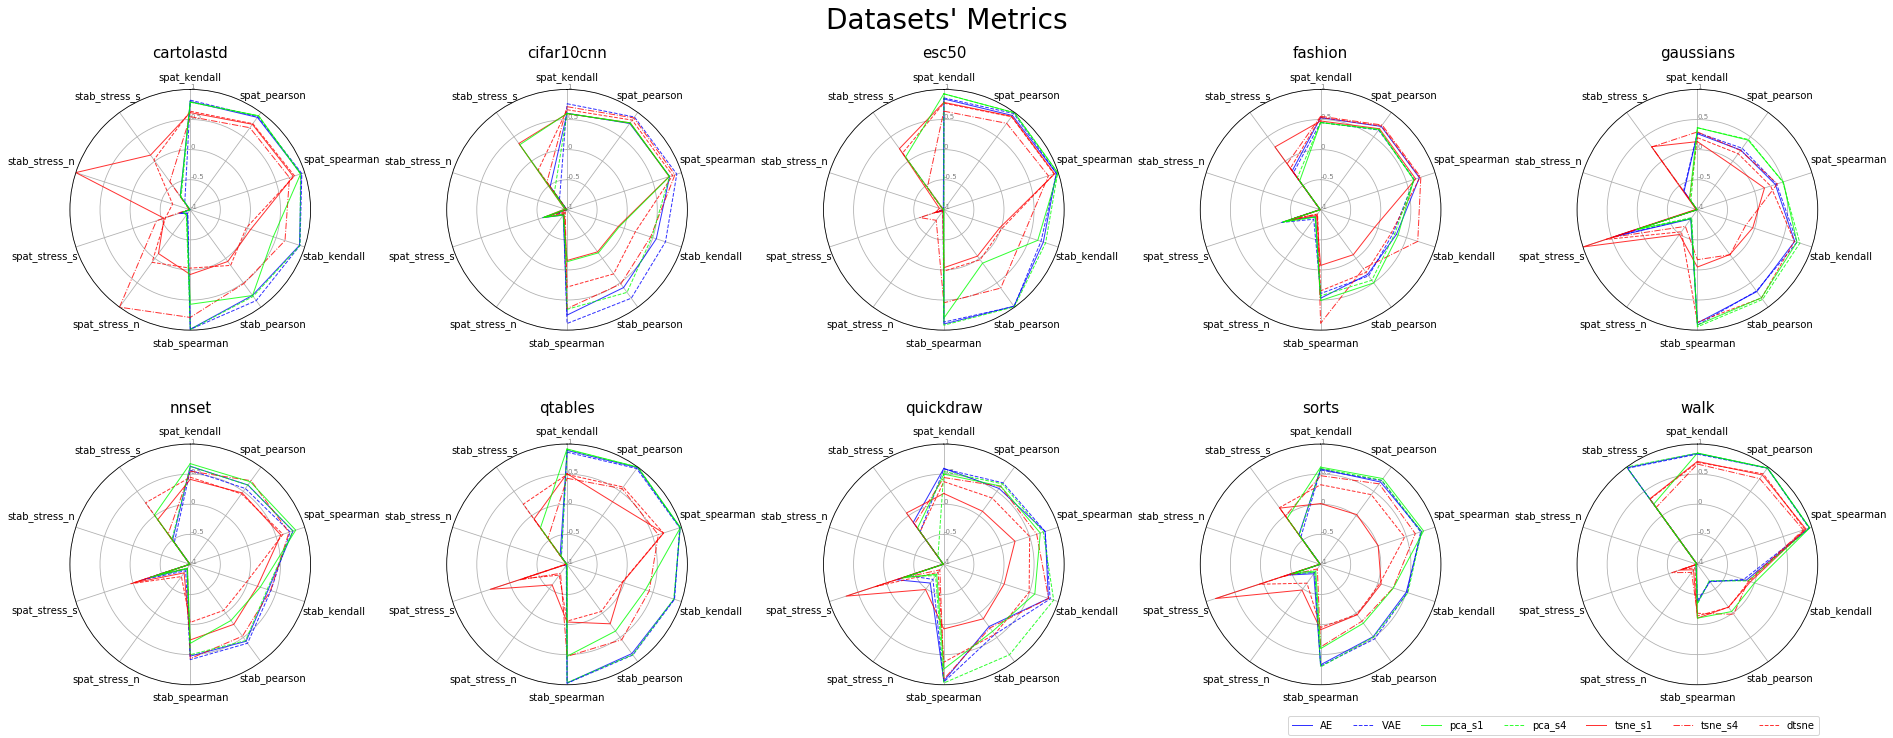

In [465]:
import matplotlib.pyplot as plt
from math import pi

datasets = np.array(sorted(list(df_metrics_filtered_normalized.groupby('dataset').indices)))
print(datasets)
df_values_only = df_metrics_filtered_normalized.drop(columns=['dataset', 'method'])
categories = sorted(list([c for c in df_values_only.columns if not 'stress' in c])) + sorted(list([c for c in df_values_only.columns if 'stress' in c]))
n = len(categories)

colors = [(0,0,1), (0,0,1), (1,0,0), (1,0,0), (1,0,0), (0,1,0), (0,1,0)]  # Specifically for this set of 7 methods
linestyle = ['-', '--', '-', '-.', '--', '-', '--']

print("Categories:", n, categories)

angles = [n_ / float(n) * 2 * pi for n_ in range(n)]
angles += angles[:1]

fig, axes = plt.subplots(2, 5, constrained_layout=True, subplot_kw=dict(polar=True))
fig.set_size_inches(50/1.9, 50/5)

leg_handles = []
leg_labels = []
for dss, axs in zip(datasets.reshape(axes.shape), axes):
    for ds, ax in zip(dss, axs):
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.tick_params(axis='x', which='major', pad=25)
        ticks = [tick for tick in ax.get_xaxis().get_major_ticks()]
        ticks[0].set_pad(2.)
        ticks[1].set_pad(10.)
        ticks[2].set_pad(28.)
        ticks[3].set_pad(20.)
        ticks[4].set_pad(10.)
        ticks[5].set_pad(2.)
        ticks[6].set_pad(12.)
        ticks[7].set_pad(22.)
        ticks[8].set_pad(26.)
        ticks[9].set_pad(10.)

        ax.set_rlabel_position(0)
        ax.set_yticks([-1, -0.5, 0, 0.5, 1])
        ax.set_yticklabels(["-1", "-0.5", "0", "0.5", "1"], color='grey', size=7)
        ax.set_ylim(-1,1)

        df = df_metrics_filtered_normalized.groupby('dataset').get_group(ds).drop(columns=['dataset'])
        for style, color, method in zip(linestyle, colors, df['method'].values[:]):
            data = df[df['method'] == method].drop(columns=['method']).values.flatten().tolist()
            data += data[:1]
            ax.plot(angles, data, linewidth=1, linestyle=style, c=color, alpha=0.8, label=method)

        ax.set_title(ds, fontsize=15, pad=20)
        handles, labels = ax.get_legend_handles_labels()
        leg_handles.append(handles)
        leg_labels.append(labels)

leg_labels = np.array(leg_labels).reshape(1,-1)[0]
leg_handles = np.array(leg_handles).reshape(1,-1)[0]
i = np.arange(len(leg_labels))
filter_ = np.array([])
unique_labels = list(set(leg_labels))
for ul in unique_labels:
    filter_ = np.append(filter_, i[np.array(leg_labels) == ul][0])
leg_handles = np.array([leg_handles[int(f)] for f in filter_])
leg_labels = np.array([leg_labels[int(f)] for f in filter_])
leg_order = [1, 4, 0, 5, 6, 3, 2]
leg_handles = leg_handles[leg_order]
leg_labels = leg_labels[leg_order]

# upper left bbox = (0.0375, 0.97)
fig.legend(leg_handles, leg_labels, bbox_to_anchor=(0.9625, 0.0375), ncol=len(leg_labels))
fig.suptitle("Datasets' Metrics", fontsize=28, y=1.01)
fig.tight_layout()

fig.savefig('Figs/radar_metrics.png', bbox_inches='tight')